# Prerequisites

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score , accuracy_score

import nltk
from nltk.stem.porter import PorterStemmer

import gensim

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D , Dropout,Conv1D
from keras.optimizers import Adam

# Reading data

reading data and showing 

In [2]:
all_data = pd.read_csv("data.csv",na_values = "[]" , keep_default_na=True)

In [3]:
print(all_data.head())


      product_id                                            title      vendor  \
0  3937721221199  Fidele Super Premium Adult Large Breed Dog Food      Fidele   
1  7353058033889                  Foldable Pet Toys Linen Storage   Cap Point   
2  6594773549129                                   Bok Dok Diaper   Pets Home   
3  4802008318014                            Tastybone Toy Chicken   TastyBone   
4  1779705151539              Leather Leash Tab - Short Dog Leash  Mighty Paw   

                                                tags                category  
0  ['Adult', 'Bangalore', 'Chennai', 'Chicken', '...  Animals & Pet Supplies  
1                                                NaN  Animals & Pet Supplies  
2  ['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...  Animals & Pet Supplies  
3                                                NaN  Animals & Pet Supplies  
4                 ['Leash', 'Leash Tab', 'Training']  Animals & Pet Supplies  


In [4]:
all_categories = pd.unique(all_data["category"])

print(all_categories)

['Animals & Pet Supplies' 'Apparel & Accessories' 'Arts & Entertainment'
 'Baby & Toddler' 'Business & Industrial' 'Cameras & Optics' 'Electronics'
 'Food, Beverages & Tobacco' 'Furniture' 'Hardware' 'Health & Beauty'
 'Home & Garden' 'Luggage & Bags' 'Media' 'Office Supplies'
 'Religious & Ceremonial' 'Software' 'Sporting Goods' 'Toys & Games'
 'Vehicles & Parts']


In [5]:
len(all_categories)

20

# Analyzing Data

checking number of samples in each cateory

In [5]:
all_categories_information = {}

for category in all_categories:
    num_samples = len(all_data[all_data["category"] == category])
    print("Number of samples from category of ",category," : ", num_samples)
    all_categories_information[category] = num_samples

Number of samples from category of  Animals & Pet Supplies  :  500
Number of samples from category of  Apparel & Accessories  :  1000
Number of samples from category of  Arts & Entertainment  :  200
Number of samples from category of  Baby & Toddler  :  200
Number of samples from category of  Business & Industrial  :  100
Number of samples from category of  Cameras & Optics  :  50
Number of samples from category of  Electronics  :  100
Number of samples from category of  Food, Beverages & Tobacco  :  400
Number of samples from category of  Furniture  :  200
Number of samples from category of  Hardware  :  50
Number of samples from category of  Health & Beauty  :  400
Number of samples from category of  Home & Garden  :  400
Number of samples from category of  Luggage & Bags  :  400
Number of samples from category of  Media  :  300
Number of samples from category of  Office Supplies  :  100
Number of samples from category of  Religious & Ceremonial  :  20
Number of samples from category

## Plotting data

Text(0, 0.5, 'Number of samples')

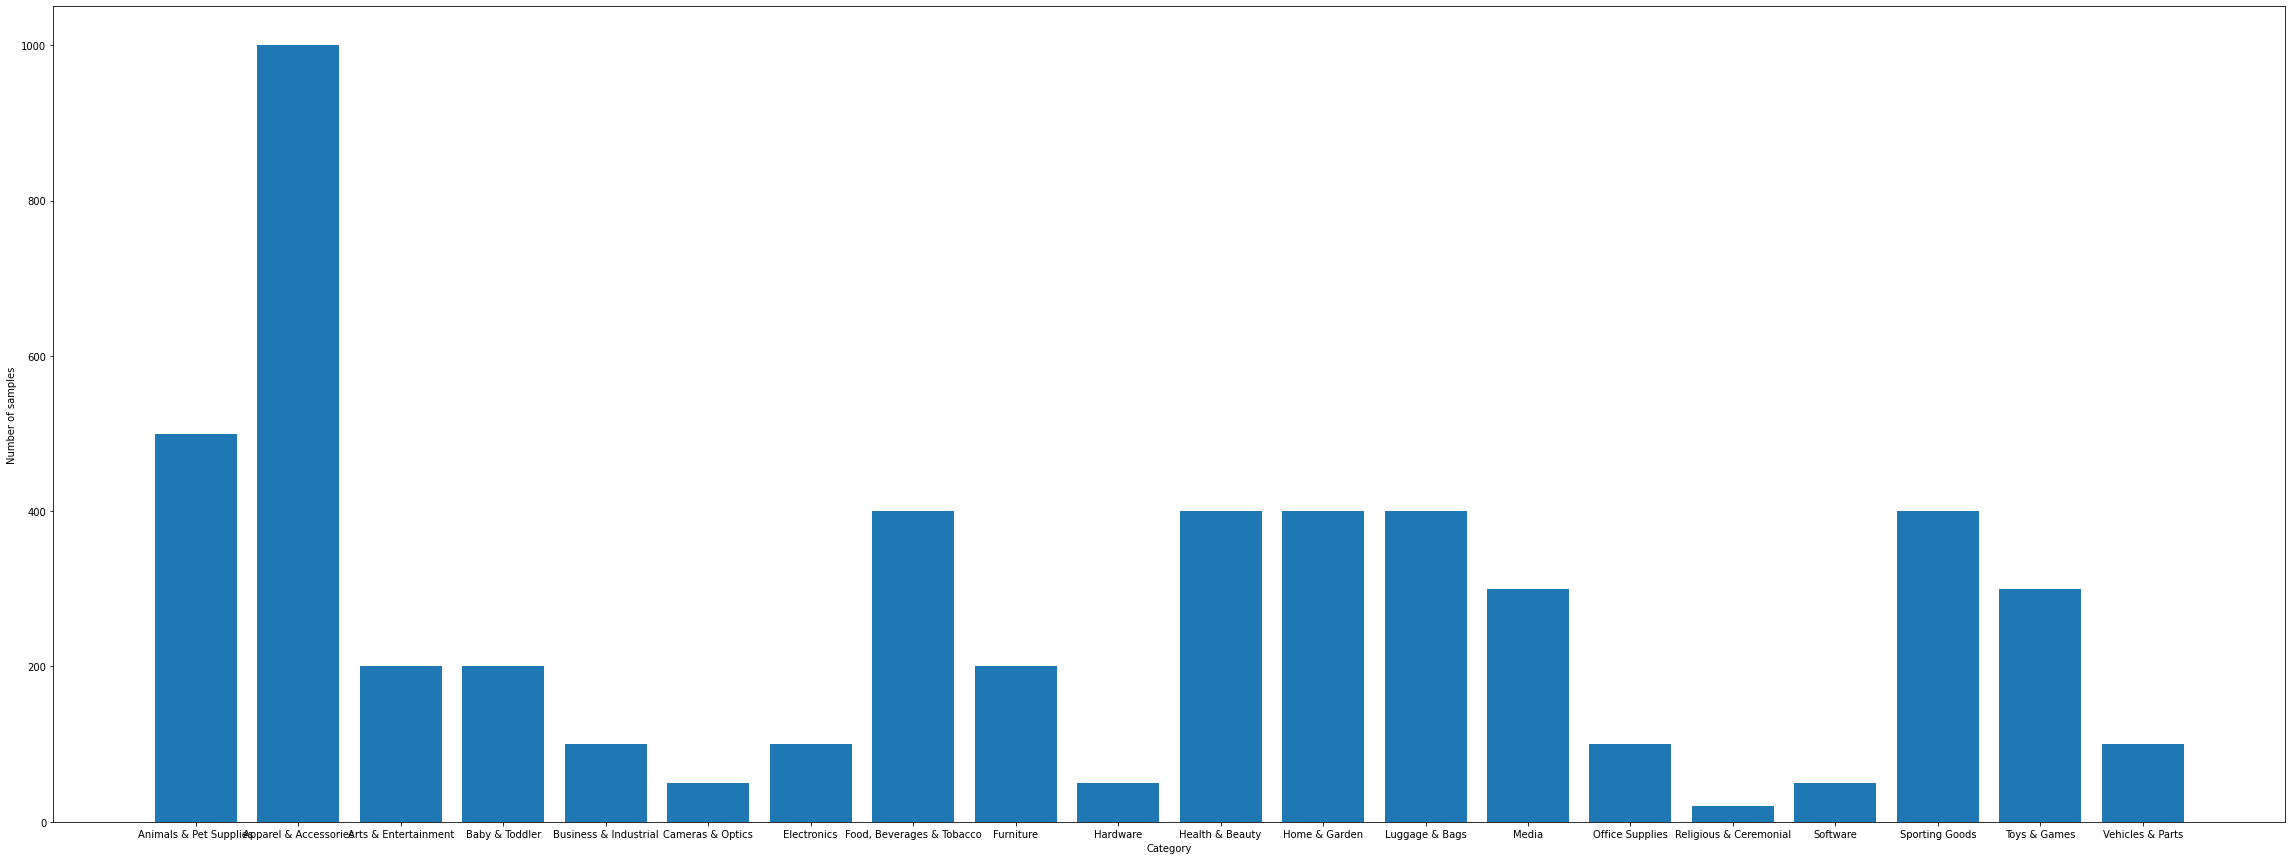

In [6]:
plt.rcParams["figure.figsize"] = (40,15)
plt.bar(list(all_categories_information.keys()), list(all_categories_information.values()))
plt.xlabel('Category')
plt.ylabel('Number of samples')


**We see that the dataset is unbalanced**


# Data Preprocessing

Delete product_id colum because it is excess and not needed.

In [7]:
all_data.pop("product_id")

0       3937721221199
1       7353058033889
2       6594773549129
3       4802008318014
4       1779705151539
            ...      
5265    4637089464407
5266    4996632444987
5267    5528541003927
5268    1395163889730
5269    3535679324240
Name: product_id, Length: 5270, dtype: int64

### define mapping class names to labels

In [8]:

categories_to_label = {}
labels_to_categories = {}

for idx, category in enumerate(all_categories):
    categories_to_label[category] = idx
    labels_to_categories[idx] = category

print(categories_to_label)
print(labels_to_categories)


{'Animals & Pet Supplies': 0, 'Apparel & Accessories': 1, 'Arts & Entertainment': 2, 'Baby & Toddler': 3, 'Business & Industrial': 4, 'Cameras & Optics': 5, 'Electronics': 6, 'Food, Beverages & Tobacco': 7, 'Furniture': 8, 'Hardware': 9, 'Health & Beauty': 10, 'Home & Garden': 11, 'Luggage & Bags': 12, 'Media': 13, 'Office Supplies': 14, 'Religious & Ceremonial': 15, 'Software': 16, 'Sporting Goods': 17, 'Toys & Games': 18, 'Vehicles & Parts': 19}
{0: 'Animals & Pet Supplies', 1: 'Apparel & Accessories', 2: 'Arts & Entertainment', 3: 'Baby & Toddler', 4: 'Business & Industrial', 5: 'Cameras & Optics', 6: 'Electronics', 7: 'Food, Beverages & Tobacco', 8: 'Furniture', 9: 'Hardware', 10: 'Health & Beauty', 11: 'Home & Garden', 12: 'Luggage & Bags', 13: 'Media', 14: 'Office Supplies', 15: 'Religious & Ceremonial', 16: 'Software', 17: 'Sporting Goods', 18: 'Toys & Games', 19: 'Vehicles & Parts'}


This is for showing how much explicit null exists in dataframe

In [9]:

all_data.isnull().sum()


title         0
vendor        3
tags        460
category      0
dtype: int64

As it shows we have missing values in two columns : "vendor" , "tags"

We should fill these with some corresponding appropriate texts.

so for handling missing information and preprocessing we have some ideas:

1. 

 Removing all rows with missing values: this is not good idae in this case, because the number of missed values are realtively great and by this we miss very information.
 

2.

 Labeling "tags" missed values with "UNKNOWN" (an extra label for showing misinfomation).
 this solution adds bias to Model and other better solutions exist. 


3.

**The better solution is to fill missing information based on other colums.**





### handle missing information in "vendor"

For handling missing information in this column I had an idea:
- Select data with same category with misvalued data category
- The nearest neighbour of the misvalued data is the upper or downer row, so we choose it
- choose the neighbour "vendor" as misvalued "vendor" in this column

This is because the vendors in same categories probably have same products.



In [10]:
index_list_of_missing_information = all_data[all_data["vendor"].isnull()].index.to_list()

for idx in index_list_of_missing_information:
    if all_data.loc[idx,"category"] == all_data.loc[idx-1,"category"]:
        
        all_data.loc[idx,"vendor"] = all_data.loc[idx-1,"vendor"]
        
    elif all_data.loc[idx,"category"] == all_data.loc[idx+1,"category"]:
       
        all_data.loc[idx,"vendor"] = all_data.loc[idx+1,"vendor"]
    
    print(all_data.loc[idx,:])
    


title       WYSIWYG Rainbow Bubble Tip Anemone * RBTA * Li...
vendor                                       Always Whiskered
tags        ['AFCO-', 'AFCO-EB', 'AFCO-EB124448705859', 'A...
category                               Animals & Pet Supplies
Name: 457, dtype: object
title                  Cinnamon Honey Stix
vendor                   Bellwoods Brewery
tags        ['Honey', 'Retail', 'Spently']
category         Food, Beverages & Tobacco
Name: 2499, dtype: object
title       SCHWINN BICYCLE HUB ROAD BIKE FRONT QUICK RELEASE
vendor                                               Lib Tech
tags                                                      NaN
category                                       Sporting Goods
Name: 4673, dtype: object


### handle missing information in "tags"

For handling missing information in this column I had an idea:
- Select the "title" in this row which has misvalued "tags".
- Tokenize and split "title" words and label each word as a "tag" in "tags" column.


This is because It can be seen that the words in tags column are very similar to title words.



In [11]:
index_list_of_missing_information = all_data[all_data["tags"].isnull()].index.to_list()

for idx in index_list_of_missing_information:
    tag_string = "["
    for title_word in all_data.loc[idx,"title"].split(" "):
        tag_string = tag_string + "'" +  title_word + "',"

    tag_string = tag_string[0:-1]
    tag_string +="]"
    all_data.loc[idx,"tags"] = tag_string
    
    


In [12]:
all_data.isnull().sum()

title       0
vendor      0
tags        0
category    0
dtype: int64

### some cleaning data on texts

In this section we want to do some cleanings.

The final task is a text classification task, so:

1. removing sentences with some extra postfixes and prefixes such as .com, .org ,... in data. this can be improve model accuracy, because these are meaningless words in final task and can add bias to final model.

2. removing mainingless chars such as &,^,%,... and filter any non-English char


3. Normalizing data : lowercasing all chars for removing bias and difference between uppercases and lowercases chars.

4.  Removing Numbers from data: because is not important.

5. Stemming :  for getting the root of each word : it means that jumps , jumping, jumped  all of them are converted to "jump" which is root of them. and it helps model gets better because of removing difference between all shapes.
 



In [13]:

forbidden_ext = [".com", ".org" , ".co", ".(ltd)", "inc.",  "int.", ".shop", ".ie" ,".au",
                 "ltd.", ".ph" , ".in" , ".us", ".ae" , ".kw" , ".pl"]

forbidden_pre = "www."

stemmer = PorterStemmer()

for index, row in all_data.iterrows():
    
     ###### title ######
    text = row["title"].lower()
    print(text)
    
    
    result_text = ""
    for char in text :
        if char!=" ":
            if (char.isalnum()) and (not char.isnumeric()):
                result_text = result_text + char
        else:
            result_text = result_text + char
            
    
    ### stemming
    words = result_text.split(" ")
    root_words = []

    for word in words:
        root_words.append(stemmer.stem(word))
        
    result_text = " ".join(root_words)
    
    print(result_text) 
    all_data.iloc[index,0] = result_text


    
    
    ###### vendor ######
    
    text = row["vendor"].lower()
    print(text)
    
    for ext in forbidden_ext:
        if ext in text:
            
            text = text.replace(ext,"")
            
        if forbidden_pre in text:
            
            text = text.replace(forbidden_pre,"")
          
    
    result_text = ""
    for char in text :
        if char!=" ":
            if (char.isalnum()) and (not char.isnumeric()):
                result_text = result_text + char
        else:
            result_text = result_text + char
    
    print(result_text) 
            
    ### stemming
    words = result_text.split(" ")
    root_words = []

    for word in words:
        root_words.append(stemmer.stem(word))
        
    result_text = " ".join(root_words)
    
    print(result_text) 

    
    all_data.iloc[index,1] = result_text
    
    
    
    
   
    ###### tags ######
    text = ""
    print(row["tags"])
    for char in row["tags"]:
        if char == "[" or char == "'"  or char == "]" :
            continue
        
        elif char == "," or char == " " or char == "_" : 
            text = text + " "
        else:
            text = text + char
            
        
    text = " ".join(text.split())
    text = text.lower()
    
    result_text = ""
    for char in text :
        if char!=" ":
            if (char.isalnum()) and (not char.isnumeric()):
                result_text = result_text + char
        else:
            result_text = result_text + char
            
    
    ### stemming
    words = result_text.split(" ")
    root_words = []

    for word in words:
        root_words.append(stemmer.stem(word))
        
    result_text = " ".join(root_words)
    
    print(result_text) 
    all_data.iloc[index,2] = result_text 
    
    
    ### Category ####
    
    row['category'] = categories_to_label[row['category']]
    all_data.iloc[index,3] = row['category'] 
    

fidele super premium adult large breed dog food
fidel super premium adult larg breed dog food
fidele
fidele
fidel
['Adult', 'Bangalore', 'Chennai', 'Chicken', 'Doberman', 'Dog Dry Foods', 'Fidele', 'German Shepherd', 'Golden Retriever', 'Great Dane', 'HighPriority', 'Imported', 'Labrador', 'Less than 1000', 'Less than 2000', 'Less than 500', 'Mastiff', 'Orange Pet Nutrition']
adult bangalor chennai chicken doberman dog dri food fidel german shepherd golden retriev great dane highprior import labrador less than  less than  less than  mastiff orang pet nutrit
foldable pet toys linen storage
foldabl pet toy linen storag
cap point
cap point
cap point
['Foldable','Pet','Toys','Linen','Storage']
foldabl pet toy linen storag
bok dok diaper
bok dok diaper
pets home
pets home
pet home
['Brand_Pet Arabia', 'Category_Pets Home', 'Category_Small Pets Supplies', 'Type_Pet Home', 'Type_Pet Supplies']
brand pet arabia categori pet home categori small pet suppli type pet home type pet suppli
tastybone

In [14]:
print(all_data.head())

                                           title      vendor  \
0  fidel super premium adult larg breed dog food       fidel   
1                   foldabl pet toy linen storag   cap point   
2                                 bok dok diaper    pet home   
3                           tastybon toy chicken    tastybon   
4             leather leash tab  short dog leash  mighti paw   

                                                tags category  
0  adult bangalor chennai chicken doberman dog dr...        0  
1                       foldabl pet toy linen storag        0  
2  brand pet arabia categori pet home categori sm...        0  
3                               tastybon toy chicken        0  
4                              leash leash tab train        0  


# Featurizing data

Now we should convert all we have from texts to numbers and features.
Some ways exists but on my experience i Choose Word2vec.
The ways :
- Bag of Words
- Word2Vec
- Bert
...

There are some pretrained models which are trained on large datasets.
some of them are : 
- Google model
- Glove-twiiter 
...

I first chose glove-twitter-25 with 25 neurons in embedding. but the results got better when i chose the bigger model glove-twitter-50. I also used google-word2vec-300 model, but this was a huge model and was very time-consuming model for extracting feature.

In [14]:
import gensim.downloader
w2v_model = gensim.downloader.load('glove-twitter-50')
# w2v_model = gensim.downloader.load('word2vec-google-news-300')


You can check the pretrained model with any word exist in its dataset.

In [78]:
w2v_model.most_similar('cat')

[('dog', 0.9429584741592407),
 ('pet', 0.8726722002029419),
 ('kitty', 0.8676421046257019),
 ('bear', 0.8655619025230408),
 ('monkey', 0.8506731390953064),
 ('pig', 0.8369912505149841),
 ('puppy', 0.8335511684417725),
 ('kitten', 0.829558789730072),
 ('cats', 0.8218452334403992),
 ('dogs', 0.8203402161598206)]

In [6]:
w2v_model["dog"].shape

(300,)

This a function which gets a cleaned sentence with just space betwenn words.


in This function I put every splitted word into word2vec model and get embedding. After that i average the embeddings over a sentence. I mean averaging embedding show of each word in a sentence given.




First of all  i checked whether the performance improves by not averaging and just adding or not and the result was : Yes! by averaging word embeddings, final results get better.



In [15]:
def featurize_sentence(sentence , embedding_size=25):
    words =sentence.split(" ")
    
    embeddings = np.zeros((embedding_size))
    
    
    for word in words:
        if word in w2v_model.index_to_key:
            
            embeddings +=w2v_model[word]
     
           
    
    return embeddings
        
    

In This section I am going to featurize each text column as a sentence. so we have three averaged word embeddings of each colum. After that it can be a choice between concatinating features or averaging all. 

I tried both of them and the results were better when concatinating.

In [16]:
embedding_size = 50
all_features = np.zeros((all_data.shape[0], 3*embedding_size))
all_labels = np.zeros((all_data.shape[0],))

for index, row in all_data.iterrows():
    title_embedding = featurize_sentence(row["title"],embedding_size)
    # print("title_embedding_shape : " ,title_embedding.shape)
    
    vendor_embedding = featurize_sentence(row["vendor"],embedding_size)
    # print("vendor_embedding_shape : " ,vendor_embedding.shape)
    
    tags_embedding = featurize_sentence(row["tags"],embedding_size)
    # print("tags_embedding_shape : " ,tags_embedding.shape)
    
    
    all_features[index] = np.transpose(np.hstack([title_embedding,vendor_embedding,tags_embedding]))
    # all_features[index] = title_embedding + vendor_embedding + tags_embedding
    
    
    all_labels[index] = row["category"]
    

print(all_features.shape)
print(all_labels.shape)


(5270, 150)
(5270,)


# Train/Test Splitting

20% of data for testing 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(all_features,all_labels, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
type(X_train)

(4216, 150)
(4216,)
(1054, 150)
(1054,)


numpy.ndarray

# Model selection / Training / Evaluation

## Random Forest classifier

### trainig with n_estimators=100

In [21]:
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=100,class_weight = 'balanced', max_features = 'auto')
clf_model = clf.fit(X_train, y_train)

### Evaluation and Metrics with n_estimators=100

In [22]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [23]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))X_test
print(classification_report(y_test,y_pred))


Precision: 0.672 / Recall: 0.58 / Accuracy: 0.58
              precision    recall  f1-score   support

         0.0       0.73      0.78      0.75       109
         1.0       0.41      0.93      0.57       207
         2.0       0.92      0.29      0.44        42
         3.0       0.89      0.34      0.49        50
         4.0       1.00      0.31      0.48        16
         5.0       1.00      0.33      0.50         9
         6.0       0.57      0.19      0.29        21
         7.0       0.73      0.80      0.76        79
         8.0       1.00      0.31      0.47        42
         9.0       0.00      0.00      0.00         7
        10.0       0.56      0.43      0.49        67
        11.0       0.55      0.34      0.42        64
        12.0       0.76      0.59      0.66        82
        13.0       0.74      0.88      0.81        66
        14.0       1.00      0.04      0.08        23
        15.0       1.00      1.00      1.00         1
        16.0       1.00      0.3

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/sit

### trainig with n_estimators=1000

In [24]:
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=1000,class_weight = 'balanced', max_features = 'auto')
clf_model = clf.fit(X_train, y_train)

### Evaluation and Metrics with n_estimators=100

In [25]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [26]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.732 / Recall: 0.612 / Accuracy: 0.612
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       109
         1.0       0.40      0.96      0.57       207
         2.0       1.00      0.33      0.50        42
         3.0       0.95      0.40      0.56        50
         4.0       1.00      0.31      0.48        16
         5.0       1.00      0.33      0.50         9
         6.0       0.83      0.24      0.37        21
         7.0       0.78      0.85      0.81        79
         8.0       1.00      0.38      0.55        42
         9.0       0.00      0.00      0.00         7
        10.0       0.74      0.52      0.61        67
        11.0       0.68      0.33      0.44        64
        12.0       0.84      0.56      0.67        82
        13.0       0.81      0.89      0.85        66
        14.0       1.00      0.04      0.08        23
        15.0       1.00      1.00      1.00         1
        16.0       1.00      0

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/sit

## KNN

### training

In [28]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=15)
clf_model = clf.fit(X_train, y_train)


### Evaluation and Metrics

In [29]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [30]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.515 / Recall: 0.488 / Accuracy: 0.488
              precision    recall  f1-score   support

         0.0       0.45      0.81      0.58       109
         1.0       0.47      0.78      0.59       207
         2.0       0.59      0.24      0.34        42
         3.0       0.46      0.38      0.42        50
         4.0       1.00      0.25      0.40        16
         5.0       0.18      0.22      0.20         9
         6.0       0.62      0.24      0.34        21
         7.0       0.61      0.46      0.52        79
         8.0       0.42      0.19      0.26        42
         9.0       0.00      0.00      0.00         7
        10.0       0.54      0.40      0.46        67
        11.0       0.29      0.22      0.25        64
        12.0       0.44      0.52      0.48        82
        13.0       0.67      0.70      0.68        66
        14.0       1.00      0.04      0.08        23
        15.0       0.00      0.00      0.00         1
        16.0       1.00      0

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/sit

## Logistic regression

### training

In [32]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=10,penalty='l2', solver='newton-cg')
clf_model = clf.fit(X_train, y_train)

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


### metrics and evaluation

In [33]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [34]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.596 / Recall: 0.586 / Accuracy: 0.586
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.75       109
         1.0       0.71      0.69      0.70       207
         2.0       0.53      0.48      0.50        42
         3.0       0.56      0.58      0.57        50
         4.0       0.24      0.31      0.27        16
         5.0       0.25      0.44      0.32         9
         6.0       0.36      0.48      0.41        21
         7.0       0.65      0.67      0.66        79
         8.0       0.69      0.52      0.59        42
         9.0       0.06      0.14      0.08         7
        10.0       0.60      0.54      0.57        67
        11.0       0.40      0.41      0.40        64
        12.0       0.73      0.74      0.74        82
        13.0       0.71      0.80      0.75        66
        14.0       0.31      0.22      0.26        23
        15.0       0.33      1.00      0.50         1
        16.0       0.21      0

## Decision tree

#### training

In [35]:
from sklearn import tree
# choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=20,criterion='gini')
clf_model = clf.fit(X_train, y_train)

### metrics and evaluation

In [36]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [37]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.337 / Recall: 0.331 / Accuracy: 0.331
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52       109
         1.0       0.46      0.43      0.45       207
         2.0       0.28      0.26      0.27        42
         3.0       0.26      0.22      0.24        50
         4.0       0.23      0.31      0.26        16
         5.0       0.00      0.00      0.00         9
         6.0       0.17      0.19      0.18        21
         7.0       0.36      0.38      0.37        79
         8.0       0.24      0.19      0.21        42
         9.0       0.00      0.00      0.00         7
        10.0       0.26      0.36      0.30        67
        11.0       0.17      0.16      0.16        64
        12.0       0.37      0.37      0.37        82
        13.0       0.50      0.41      0.45        66
        14.0       0.00      0.00      0.00        23
        15.0       0.25      1.00      0.40         1
        16.0       0.19      0

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/sit

## Adaboost

### training

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
 
# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=2)
clf = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)
clf_model = clf.fit(X_train, y_train)

### metrics and ecaluation

In [39]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [40]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.266 / Recall: 0.302 / Accuracy: 0.302
              precision    recall  f1-score   support

         0.0       0.62      0.51      0.56       109
         1.0       0.24      0.99      0.38       207
         2.0       0.00      0.00      0.00        42
         3.0       0.00      0.00      0.00        50
         4.0       0.00      0.00      0.00        16
         5.0       0.00      0.00      0.00         9
         6.0       0.00      0.00      0.00        21
         7.0       0.45      0.35      0.40        79
         8.0       0.00      0.00      0.00        42
         9.0       0.00      0.00      0.00         7
        10.0       0.50      0.01      0.03        67
        11.0       0.67      0.03      0.06        64
        12.0       0.00      0.00      0.00        82
        13.0       0.79      0.41      0.54        66
        14.0       0.00      0.00      0.00        23
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mostafa/anaconda3/lib/python3.8/sit

## Linear SVM

### training

In [41]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf_model = clf.fit(X_train, y_train)

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### metrics and evaluation

In [42]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [43]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.576 / Recall: 0.565 / Accuracy: 0.565
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       109
         1.0       0.68      0.64      0.66       207
         2.0       0.52      0.36      0.42        42
         3.0       0.60      0.52      0.56        50
         4.0       0.27      0.19      0.22        16
         5.0       0.23      0.33      0.27         9
         6.0       0.50      0.43      0.46        21
         7.0       0.50      0.80      0.61        79
         8.0       0.38      0.62      0.47        42
         9.0       0.17      0.14      0.15         7
        10.0       0.65      0.55      0.60        67
        11.0       0.43      0.28      0.34        64
        12.0       0.54      0.82      0.65        82
        13.0       0.75      0.77      0.76        66
        14.0       0.67      0.17      0.28        23
        15.0       0.33      1.00      0.50         1
        16.0       0.14      0

## Shallow DNN

### Data preparation

In [44]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
all_labels = all_labels.reshape(len(all_labels), 1)
all_labels_onehot_encoded = np.array(onehot_encoder.fit_transform(all_labels))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(all_features,all_labels_onehot_encoded, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
type(X_train)

(4216, 150)
(4216, 20)
(1054, 150)
(1054, 20)


numpy.ndarray

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
type(X_train)

(3794, 150)
(3794, 20)
(422, 150)
(422, 20)


numpy.ndarray

### training

In [51]:


clf=Sequential()

clf.add(Dense(512, activation='softmax'))
clf.add(Dropout(0.5))
clf.add(Dense(50, activation='softmax'))
clf.add(Dropout(0.5))
clf.add(Dense(20, activation='softmax'))
# compile the clf
optimzer = Adam(learning_rate=0.01, clipvalue=0.5) # clip value to avoid the gradient exploding

clf.compile(optimizer=optimzer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])

# fit the clf
history = clf.fit(X_train, y_train, 
                    batch_size=2048, 
                    epochs=2000,  
                    verbose=2,
                    validation_data=(X_val,y_val))

Epoch 1/2000
2/2 - 0s - loss: 2.9880 - acc: 0.0854 - val_loss: 2.9670 - val_acc: 0.1919
Epoch 2/2000
2/2 - 0s - loss: 2.9615 - acc: 0.1518 - val_loss: 2.9432 - val_acc: 0.1919
Epoch 3/2000
2/2 - 0s - loss: 2.9373 - acc: 0.1587 - val_loss: 2.9211 - val_acc: 0.1919
Epoch 4/2000
2/2 - 0s - loss: 2.9147 - acc: 0.1663 - val_loss: 2.9004 - val_acc: 0.1919
Epoch 5/2000
2/2 - 0s - loss: 2.8929 - acc: 0.1761 - val_loss: 2.8812 - val_acc: 0.1919
Epoch 6/2000
2/2 - 0s - loss: 2.8726 - acc: 0.1845 - val_loss: 2.8633 - val_acc: 0.1919
Epoch 7/2000
2/2 - 0s - loss: 2.8544 - acc: 0.1916 - val_loss: 2.8468 - val_acc: 0.1919
Epoch 8/2000
2/2 - 0s - loss: 2.8368 - acc: 0.1924 - val_loss: 2.8316 - val_acc: 0.1919
Epoch 9/2000
2/2 - 0s - loss: 2.8214 - acc: 0.1964 - val_loss: 2.8175 - val_acc: 0.1919
Epoch 10/2000
2/2 - 0s - loss: 2.8066 - acc: 0.2008 - val_loss: 2.8044 - val_acc: 0.1919
Epoch 11/2000
2/2 - 0s - loss: 2.7915 - acc: 0.2024 - val_loss: 2.7922 - val_acc: 0.1919
Epoch 12/2000
2/2 - 0s - loss:

KeyboardInterrupt: 

### metrics and evaluation

In [ ]:
y_test = np.argmax(y_test, axis =1 )
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

In [53]:

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


Precision: 0.576 / Recall: 0.565 / Accuracy: 0.565
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       109
           1       0.68      0.64      0.66       207
           2       0.52      0.36      0.42        42
           3       0.60      0.52      0.56        50
           4       0.27      0.19      0.22        16
           5       0.23      0.33      0.27         9
           6       0.50      0.43      0.46        21
           7       0.50      0.80      0.61        79
           8       0.38      0.62      0.47        42
           9       0.17      0.14      0.15         7
          10       0.65      0.55      0.60        67
          11       0.43      0.28      0.34        64
          12       0.54      0.82      0.65        82
          13       0.75      0.77      0.76        66
          14       0.67      0.17      0.28        23
          15       0.33      1.00      0.50         1
          16       0.14      0

## Deep NN

### Data preparation

In [18]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
all_labels = all_labels.reshape(len(all_labels), 1)
all_labels_onehot_encoded = np.array(onehot_encoder.fit_transform(all_labels))
X_train, X_test, y_train, y_test = train_test_split(all_features,all_labels_onehot_encoded, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
type(X_train)


(4216, 150)
(4216, 20)
(1054, 150)
(1054, 20)


numpy.ndarray

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
type(X_train)


(3794, 150)
(3794, 20)
(422, 150)
(422, 20)


numpy.ndarray

### training

In [ ]:
clf=Sequential()

clf.add(Conv1D(128, kernel_size = 5, activation='softmax'))
clf.add(Dropout(0.5))
clf.add(Dense(50, activation='softmax'))
clf.add(Dropout(0.5))
clf.add(Dense(20, activation='softmax'))
# compile the clf
optimzer = Adam(learning_rate=0.01, clipvalue=0.5) # clip value to avoid the gradient exploding

clf.compile(optimizer=optimzer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])

# fit the clf
history = clf.fit(X_train, y_train, 
                    batch_size=2048, 
                    epochs=2000,  
                    verbose=2,
                    validation_data=(X_val,y_val))


### metrics and evaluation

In [ ]:


y_test = np.argmax(y_test, axis =1 )
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


## NEW

In [29]:

X_train, X_test, y_train, y_test = train_test_split(all_data["title"],all_labels, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
type(X_train)


(4216,)
(4216, 1)
(1054,)
(1054, 1)


pandas.core.series.Series

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

clf_model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
clf_model.fit(X_train,y_train)

/home/mostafa/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = clf_model.predict(X_test)

precision = round(precision_score(y_test, y_pred,average='weighted'),3)
recall = round(recall_score(y_test, y_pred,average='weighted'),3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(precision, recall, accuracy))
from sklearn.metrics import classification_report, confusion_matrix


# print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


## Doc2Vec (not completed)

In [33]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(all_data["title"],all_labels, test_size=0.20, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
type(X_train)


In [34]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
embedding_size = 50
all_features = np.zeros((all_data.shape[0], 3*embedding_size))
all_labels = np.zeros((all_data.shape[0],))

for index, row in all_data.iterrows():
    label_sentences()
    title_embedding = featurize_sentence(row["title"],embedding_size)
    # print("title_embedding_shape : " ,title_embedding.shape)
    
    vendor_embedding = featurize_sentence(row["vendor"],embedding_size)
    # print("vendor_embedding_shape : " ,vendor_embedding.shape)
    
    tags_embedding = featurize_sentence(row["tags"],embedding_size)
    # print("tags_embedding_shape : " ,tags_embedding.shape)
    
    
    all_features[index] = np.transpose(np.hstack([title_embedding,vendor_embedding,tags_embedding]))
    # all_features[index] = title_embedding + vendor_embedding + tags_embedding
    
    
    all_labels[index] = row["category"]
    

print(all_features.shape)
print(all_labels.shape)


# Result and Conclusion

All of Models are evaluated in terms of Precision, Accuracy, Recall , F1-score.

The random Forest model is the best model trained on this data. the shallow DNN is also good when is not overfitting.  So we choose Random Forest Model for this. 

Because the size of dataset is relatively small or medium, this is better to not use deep learning because it is an over design. but the best model (RFM) has accuracy near 0.73 which is not high => so we can go through deep lerning in this view for better accuracy.
So i'm working on it for using deep NN.